In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  22


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Defining and monitoring strategically aligned software improvement goals,
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processe

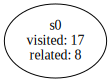

In [5]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


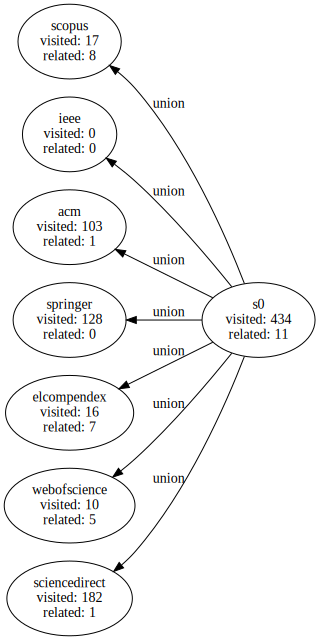

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [7]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.47058823529411764
Recall E1
0.36363636363636365


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

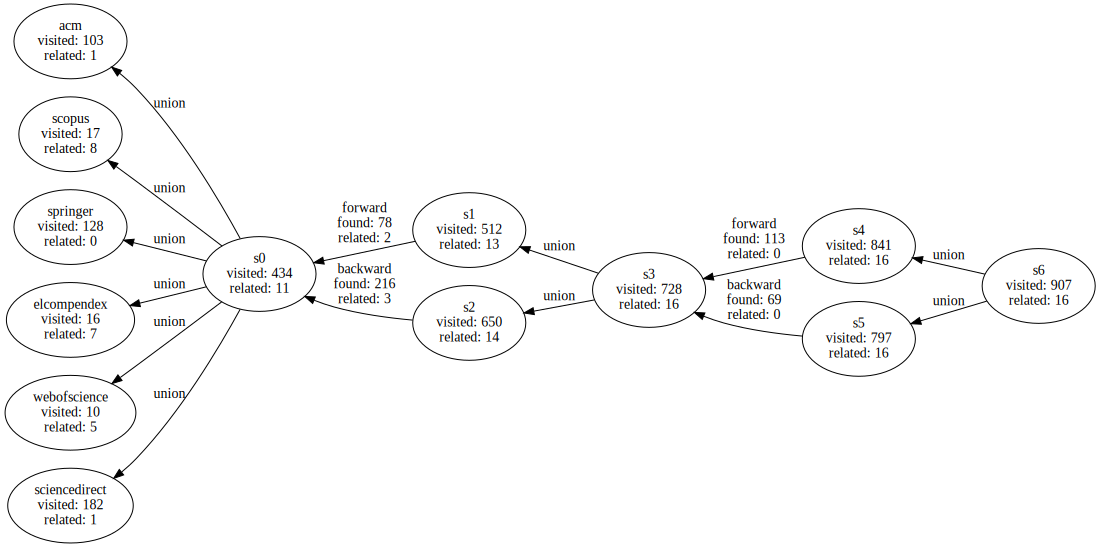

In [9]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

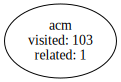

In [10]:
strategy.initial.find("acm")

In [11]:
# Visitados ACM
strategy.initial.find("acm").visited

{Multiobjective Evolutionary Algorithm for Software Project Portfolio Optimization,
 Closing the Gap: Automated Screening of Tax Returns to Identify Egregious Tax Shelters,
 A Strategic Roadmap for Navigating Academic-Industry Collaborations in Information Systems Research: Avoiding Rigor Mortis,
 How Older and Younger Adults Differ in Their Approach to Problem Solving on a Complex Website,
 Balancing Strategic Interests and Technological Requirements for Mobile Services,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 Networking Named Content,
 eGov Website Evolution Study Within Strategic Planning,
 Uncovering and Testing Archetypes of Effective Public Sector CIOs,
 Healthy Technology,
 On-die Power Grids: The Missing Link,
 Pong: Diagnosing Spatio-temporal Internet Congestion Properties,
 Scenarios, Goals, and State Machines: A Win-win Partnership for Model Synthesis,
 Problem Frames Approach to Web Services Requirements,
 A BGP-based Mechanism for Lowest-cost Routin

In [12]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals}

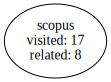

In [13]:
strategy.initial.find("scopus")

In [14]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 A comparative study of SPI approaches with ProPAM,
 Software process improvement for the airline industry,
 An approach to support the strategic alignment of software process improvement programs,
 Critical success factors in software process improvement: A systematic review,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Using strategic planning for selection of SPI processes: An experience repo

In [15]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [16]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [17]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


473

In [18]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Entropy based software processes improvement,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Linking software development and business strategy through measurement,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategic alignment of software process improvement programs using QFD}

In [19]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['trienekens2009a - Entropy based software processes improvement',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'basili2010a - Linking software development and business strategy through measurement',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'becker2008b - Strategic alignment of software process improvement programs using QFD']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [20]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Experience Reports,
 Countermeasure graphs for software security risk assessment: An action research,
 A case study in innovative process improvement: code synthesis from formal specifications,
 Scenarios, Goals, and State Machines: A Win-win Partnership for Model Synthesis,
 Problem Frames Approach to Web Services Requirements,
 The SPICE (15504) Standard,
 A lightweight framework for describing software practices,
 Access control and audit model for the multidimensional modeling of data warehouses,
 Using strategic planning for selection of SPI processes: An experience report,
 ROCKIT: Roadmap for Conversational Interaction Technologies,
 Evaluating interrater agreement in SPICE-based assessments,
 Research on Learning Software Organizations -- Past, Present, and Future,
 Selecting CMMI Appraisal Classes Based on Maturity and Openness,
 What Are the Knowledge Needs during the Project Lifecycle in an Expert Organisation?,
 Anti-counterfeiting Effectivity Analysis Using Attack and Def

#### Relacionados - Seed Set

In [21]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['albuquerque2009a - Software process improvement: Supporting the linking of the software and the business strategies',
 'plösch2011a - Software engineering strategies: aligning software process improvement with strategic goals',
 'trienekens2005a - Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL)',
 'martins2008a - ProPAMet: a Metric for process and project alignment',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative m

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [22]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Appraisal requirements for CMMI®, Version 1.1,
 ITIL - The Information Technology Infrastructure Library,
 The book,
 Aligning software-related strategies in multi- organizational settings,
 Control Objectives for Information and Related Technology,
 The Information Paradox: Realizing the Business Benefits of Information Technology,
 Information Technology - Software Process Assessment - Part 7: Guide for Use in Process Improvement,
 Organizational alignment and performance: Past, present and future,
 Telcordia Technologies: the journey to high maturity,
 Stakeholder value proposition elicitation and reconciliation,
 Root Cause Analysis and Gap Analysis - A Tale of Two Methods,
 Determining the impact of business strategies using principles from goal-oriented measurement,
 A comparative analysis of CMMI software project management by Brazilian, Indian and Chinese companies.,
 Success factors of organizational change in software process improvement,
 The ROI from Software Quality,
 Ris

In [23]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['trienekens2009a - Entropy based software processes improvement',
 'becker2008b - Strategic alignment of software process improvement programs using QFD',
 'basili2010a - Linking software development and business strategy through measurement']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [24]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']

#### Relacionados - Encontrados Via Backward e Forward

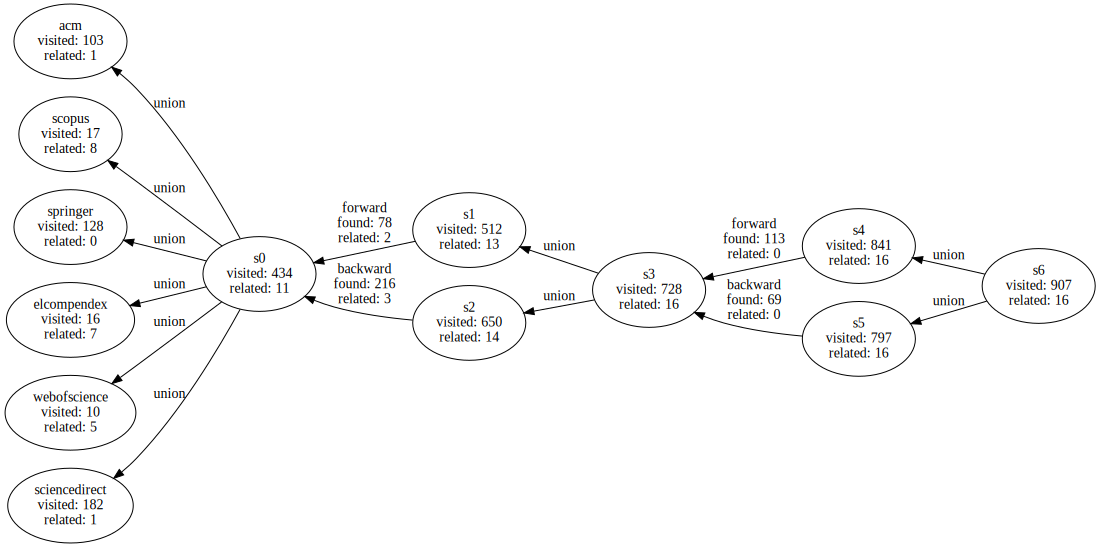

In [25]:
state

In [26]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

22

In [27]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['trienekens2009a - Entropy based software processes improvement',
  'becker2008b - Strategic alignment of software process improvement programs using QFD',
  'basili2010a - Linking software development and business strategy through measurement'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
  'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']]

In [28]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [29]:
strategy.forward??

In [30]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


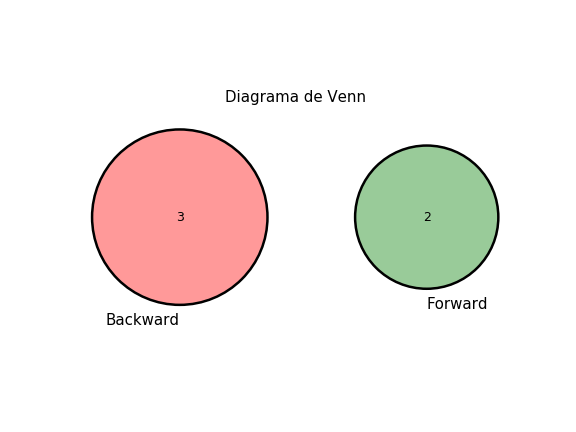

In [31]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [32]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['trienekens2009a', 'becker2008b', 'basili2010a']
Forward ['petersen2015a', 'mandić2010a']


In [33]:
state.find("s0").related @ metakey

['albuquerque2009a',
 'plösch2011a',
 'trienekens2005a',
 'martins2008a',
 'kaneko2011a',
 'wilkie2007a',
 'barreto2010a',
 'becker2008a',
 'mandić2010b',
 'guzmán2010a',
 'reiblein1997a']

In [34]:
#x = v.get_patch_by_id('100')

In [35]:
#x.set_linestyle = "black"

In [36]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [37]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward albuquerque2009a
- kaplan2000a 
- isoiec2004a 
- isoiec2004b 
- stalhane2004a 
- kim1995a 
- caivano2005a 
- reed2000a 
- salo2005b 
- adams1993a 
- wright2000a 
- thompson2000a 
- komi2004a 
- bardin1977a 
- lawrence2001a 
- cater2004a 
- prahalad1999a 
- mcnair1990a 
- dybå2003b 
- martins2007b 
- alloui2000a 
- softex2009a 
- cmusei2006a 
- boehm2000b 
- nollen2008a 
- hefner2001a 
- birk1998a 
backward plösch2011a
- mcfeeley1996a 
- isoiec1998d 
- isoiec2003b 
- venzin2003a 
- shewhart1931a 
- cmmi2006a 
- dion1993a 
- simon2002a 
backward trienekens2005a
- cattaneo2001a 
- neiger2003a 
- balla2001a 
- solingen1999a 
- mellis1998a 
- paulk1995b 
- solingen2000b 
- trienekens2001a 
- dawson2003a 
- stelzer1998a 
- debou2000a 
- kaplan2001a 
- iso2005a 
- gack2003a 
- latum1998a 
backward martins2008a
- isoiec1998a 
- pfleeger1994a 
- cmm2002a 
- isoiec1998b 
- arthur1993a 
- solingen1999a 
- paulk1993a 


#### Execução de Forward em cada artigo relacionado do S1

In [38]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward albuquerque2009a
- lópez2012a 
- ardila2013b 
- ardila2013a 
forward plösch2011a
- sharma2015a 
- stallinger2013a 
forward trienekens2005a
- chen2008a 
- glykas2011a 
- songnisai2008a 
- siritanachot2008a 
- chen2007a 
- shahzad2012a 
- lohrmann2013a 
- savioja2007a 
- glykas2014a 
- brenda2013a 
- vuk2010a 
forward martins2008a
- ollus2011a 
- jansson2015a 
- uoti2011a 
forward kaneko2011a
- kobori2014a 
- trinkenreich2015a 
- heidrich2012b 
- razón2014b 
- asghari2012a 
- teixeira2013a 
- petersen2015a related
- razón2014a 
forward wilkie2007a
- al2013a 
- lester2010a 
- laporte2009a 
- taylor2009a 
- zarour2009a 
- zarour2009b 
- zarour2011a 
- lester2007a 
- napier2009a 
forward barreto2010a
- trinkenreich2015a 
- barreto2010b 
- khraiwesh2013a 
- barcellos2010a 
- ardila2013b 
- barreto2011a 
- ardila2013a 
forward mandić2010b
- ellis2012a 
- roditi2014a 
- kobori2014a 
- papa2015a 
- fernández2011a 
- c

#### Resumo do Precision e Recall

In [39]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.01%
Precision no Snowballing E2 - Forward - 1 iteração: 0.03%
Precision no Snowballing E2 - Backward - 1 iteração: 0.01%

Precision E2 (Busca + Snowballing): 0.02%
Precision E2
0.017640573318632856
Recall E2
0.7272727272727273


In [40]:
0 /0 

ZeroDivisionError: division by zero

In [41]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [42]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

13,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,sciencedirect,0.00549451,0.0454545,-,1,182,1,182,0.00549451,0.0454545
1,webofscience,0.5,0.227273,-,5,10,5,10,0.5,0.227273
2,elcompendex,0.4375,0.318182,-,7,16,7,16,0.4375,0.318182
3,springer,0,0,-,0,128,0,128,0,0
4,scopus,0.470588,0.363636,-,8,17,8,17,0.470588,0.363636
5,acm,0.00970874,0.0454545,-,1,103,1,103,0.00970874,0.0454545
6,s0,0,0,union,11,434,0,0,0.0253456,0.5
7,s2,0.0138889,0.136364,backward,14,650,3,216,0.0215385,0.636364
8,s1,0.025641,0.0909091,forward,13,512,2,78,0.0253906,0.590909
9,s3,0,0,union,16,728,0,0,0.021978,0.727273


<IPython.core.display.Javascript object>


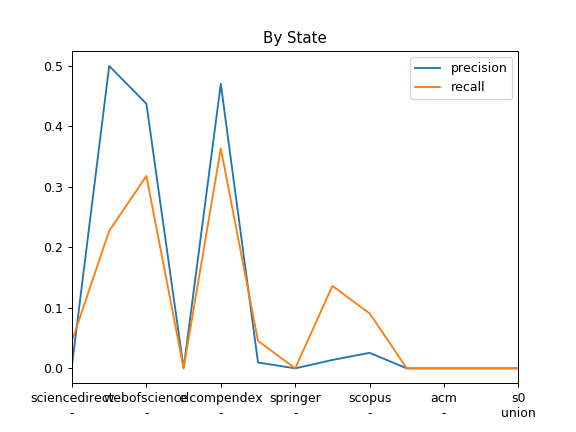

In [43]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


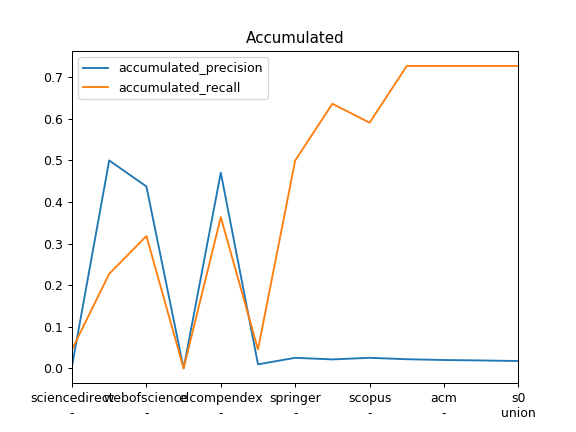

In [44]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

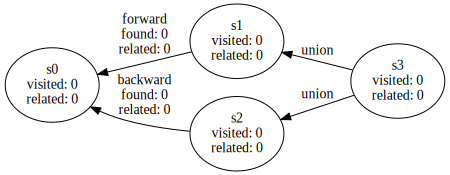

In [45]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [46]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero


## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

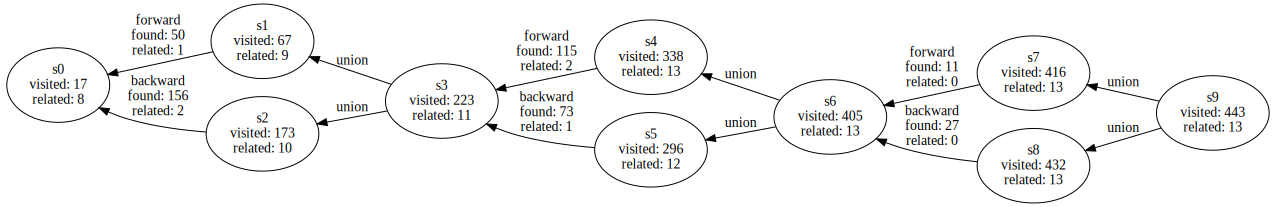

In [47]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [48]:
descreve_delta(strategy, state, "s2")


backward albuquerque2009a
- kaplan2000a 
- isoiec2004a 
- isoiec2004b 
- stalhane2004a 
- kim1995a 
- caivano2005a 
- reed2000a 
- salo2005b 
- adams1993a 
- wright2000a 
- thompson2000a 
- komi2004a 
- bardin1977a 
- lawrence2001a 
- cater2004a 
- prahalad1999a 
- mcnair1990a 
- dybå2003b 
- martins2007b 
- alloui2000a 
- softex2009a 
- cmusei2006a 
- boehm2000b 
- nollen2008a 
- hefner2001a 
- birk2002a 
- birk1998a 
backward plösch2011a
- mcfeeley1996a 
- isoiec1998d 
- isoiec2003b 
- venzin2003a 
- shewhart1931a 
- cmmi2006a 
- dion1993a 
- simon2002a 
backward martins2008a
- isoiec1998a 
- pfleeger1994a 
- cmm2002a 
- isoiec1998b 
- arthur1993a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- kuvaja1994a 
- krasner1997a 
- emam1999a 
- isoiec1998c 
- salo2005a 
- martins2007b 
backward kaneko2011a
- kowalczyk2010a 
- basili1992a 
- becker1999a 
- jaxa2012a 
- isaca2005a 
- kathuria2007a 
- ogc2002a 
- basili2009a 
- isaca2008a 
- basili2007b 
- kaplan1992a 
backward wilkie2007a
-

In [49]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [50]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [51]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [52]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.029345372460496615
Recall E4
0.5909090909090909


In [53]:
state.find("s0").related

{Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [54]:
state.find("s2").related

{Entropy based software processes improvement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Linking software development and business strategy through measurement,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [55]:
state.find("s0").visited

{Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 A comparative study of SPI approaches with ProPAM,
 Software process improvement for the airline industry,
 An approach to support the strategic alignment of software process improvement programs,
 Critical success factors in software process improvement: A systematic review,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Using strategic planning for selection of SPI processes: An experience repo

In [56]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [57]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [58]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [59]:
len(state.find("s1").delta_visited)

50

In [60]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [61]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [62]:
search_state = strategy.initial
search_state.related

{Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

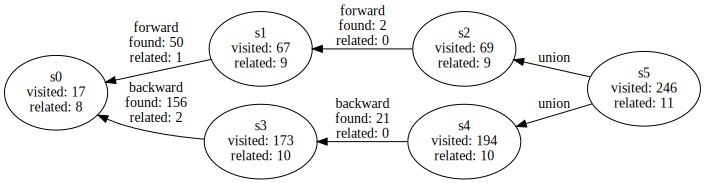

In [63]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [64]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.044715447154471545
Recall E5
0.5


In [65]:
state.find("s0").related 

{Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [66]:
state.find("s1").related 

{Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [67]:
state.find("s3").related 

{Entropy based software processes improvement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Linking software development and business strategy through measurement,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [68]:
sx, sy = state.previous[0]

sx.related & sy.related


{A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 ProPAMet: a Metric for process and project alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry}

In [69]:
sx.name

's2'

In [70]:
sy.name

's4'

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

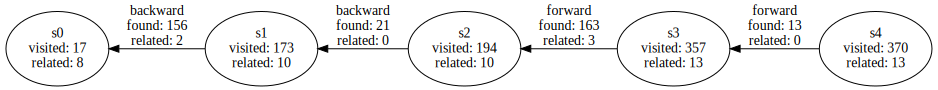

In [71]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [72]:
strategy._repeat??

In [73]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.03513513513513514
Recall E6
0.5909090909090909


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

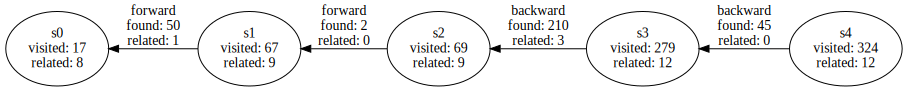

In [74]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [75]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.037037037037037035
Recall E7
0.5454545454545454


# Análise das Estratégias

In [76]:
%matplotlib notebook
import pandas as pd

In [77]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.017641,0.727273
E4,E4,0.029345,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.035135,0.590909
E7,E7,0.037037,0.545455


<IPython.core.display.Javascript object>


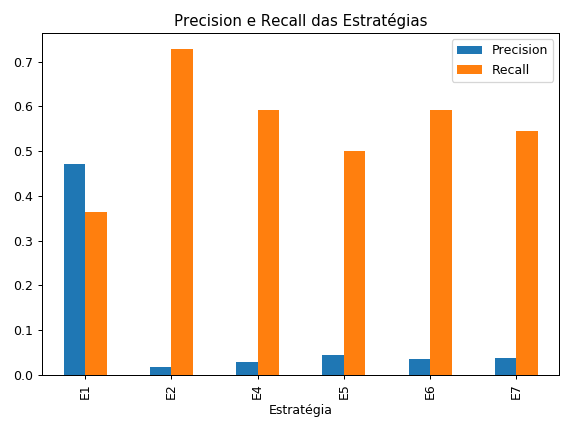

In [78]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [79]:
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.017641,0.727273
E4,E4,0.029345,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.035135,0.590909
E7,E7,0.037037,0.545455


In [83]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

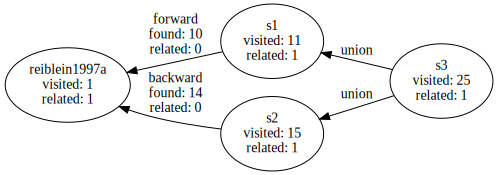

In [81]:
reload()
NAME = "reiblein1997a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state